In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Importing libraries
import numpy as np
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Importing datasets - train,test,eval

In [5]:
path = '/kaggle/input/chest-xray-dataset'

In [6]:
import os

os.listdir(path)

['data.yaml', 'val', 'test', 'train']

In [7]:
# Directory path to the training data
train = pathlib.Path(path+'/train/')
val = pathlib.Path(path+'/val/')
test = pathlib.Path(path+'/test/')

In [8]:
# Count the total number of image files within the train directory and its subdirectories
image_count = len(list(train.glob('*/*')))

print(image_count)

20450


In [9]:
# Count the total number of image files within the eval directory and its subdirectories
image_count = len(list(val.glob('*/*')))

print(image_count)

2534


In [10]:
# Count the total number of image files within the test directory and its subdirectories
image_count = len(list(test.glob('*/*')))

print(image_count)

2569


In [11]:
os.listdir(train)

['pneumonia', 'tuberculosis', 'normal']

# viewing some images

In [12]:
# List of file paths for the give category below
imgs = list(train.glob('normal/*'))

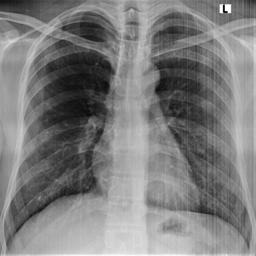

In [13]:
# Open an image using PIL
PIL.Image.open(str(imgs[2]))

# defining train & eval datasets fromdirectory using keras

this will do mapping of images with their classes[folder name]

In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
# Create a training dataset using TensorFlow's image_dataset_from_directory function

# since we already 
train_ds = tf.keras.utils.image_dataset_from_directory(
    train,                  # The directory containing the image data
    validation_split=0.001,      # Split --->0% of the data for validation, because  we already have a separate dataset for eval - or you can just remove this line
    subset="training",         # Use the subset "training" for the training dataset
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the training dataset
)

Found 20450 files belonging to 3 classes.
Using 20430 files for training.


2025-10-16 20:05:33.456249: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
# Create a validation dataset using TensorFlow's image_dataset_from_directory function - same for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    val,                  # The directory containing the image data
    validation_split=0.999,      # Split 99.9% of the data for validation
    subset="validation",       # Use the subset "validation" for the validation dataset - or you can just remove this line
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the validation dataset
)

Found 2534 files belonging to 3 classes.
Using 2531 files for validation.


In [17]:
# Displaying classes - train
class_names = train_ds.class_names
print(class_names)

['normal', 'pneumonia', 'tuberculosis']


In [18]:
# Displaying classes - eval
class_names = val_ds.class_names
print(class_names)

['normal', 'pneumonia', 'tuberculosis']


# draw some imgs from train & eval

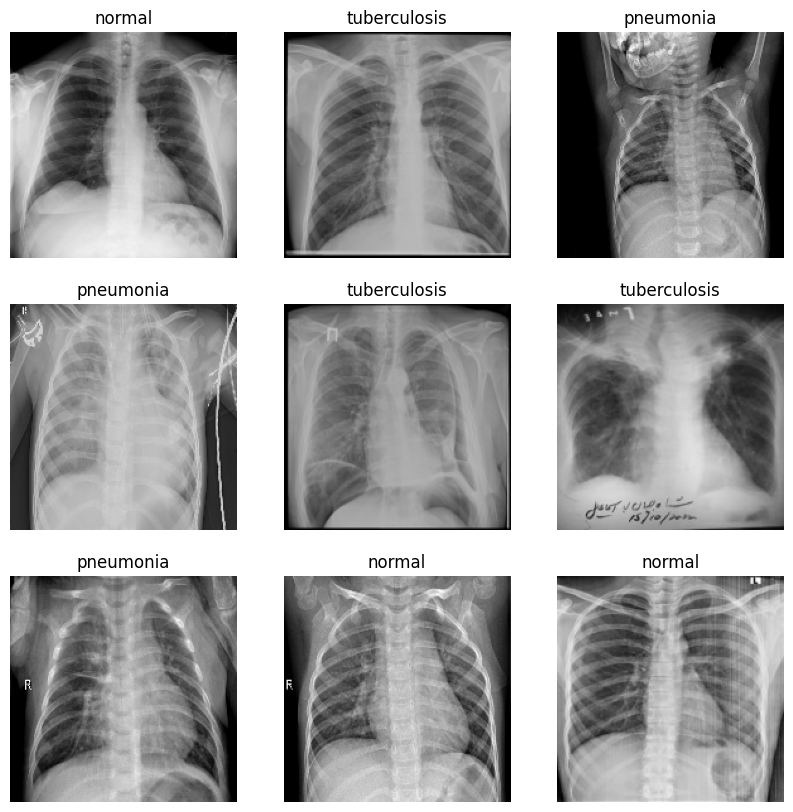

In [19]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Loop through the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Iterate through the first 9 images in the batch
    for i in range(9):
        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image as a plot and convert it to uint8 format
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title of the subplot to the corresponding class name
        plt.title(class_names[labels[i]])
        
        # Turn off the axis to remove axis labels
        plt.axis("off")


plt.show()

In [20]:
# Loop through batches of images and labels in the training dataset

for image_batch, labels_batch in train_ds:
    # Print the shape of the current image batch
    print(image_batch.shape)

    # Print the shape of the current label batch
    print(labels_batch.shape)

    break

(32, 180, 180, 3)
(32,)


In [21]:
# Define AUTOTUNE to utilize TensorFlow's automatic optimization
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, and prefetch the training dataset for improved performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for improved performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
# Create a Rescaling layer to normalize pixel values to the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

In [23]:
# Apply the normalization layer to the training dataset using the map function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Extract the first batch of images and labels from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Get the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
# Notice that the pixel values are now in the [0, 1] range.
print(np.min(first_image), np.max(first_image))

0.0005232269 1.0


In [24]:
# Calculate the number of classes based on the class names
num_classes = len(class_names)

# Create a Sequential model for image classification
model = Sequential([
  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),
  
  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),
  
  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Set the number of training epochs
epochs = 2

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)

Epoch 1/2
639/639 ━━━━━━━━━━━━━━━━━━━━ 368s 572ms/step - accuracy: 0.6906 - loss: 0.6270 - val_accuracy: 0.7460 - val_loss: 0.4815
Epoch 2/2
639/639 ━━━━━━━━━━━━━━━━━━━━ 335s 525ms/step - accuracy: 0.7558 - loss: 0.4500 - val_accuracy: 0.7539 - val_loss: 0.4374


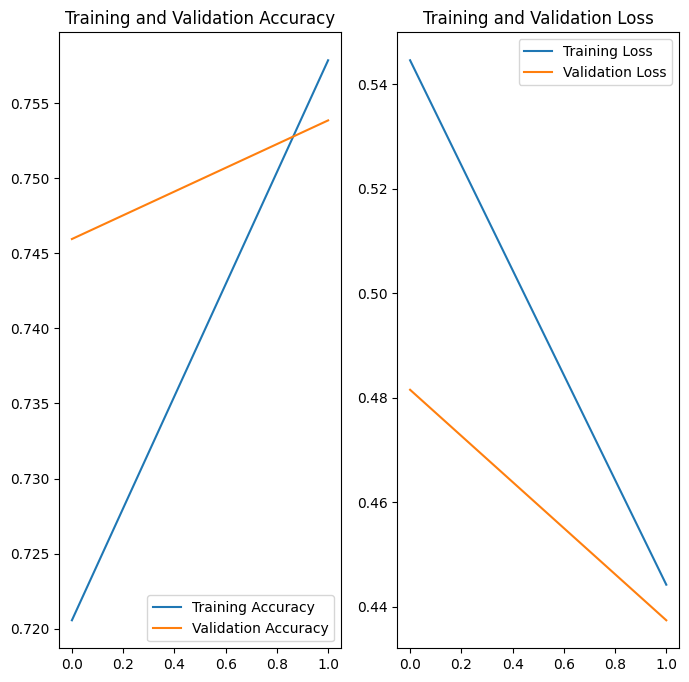

In [28]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()

# Poor Accuracy - try Data Augmentation

In [29]:
# Create a data augmentation pipeline using a Keras Sequential model
data_augmentation = keras.Sequential(
  [
    # Randomly flip images horizontally
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    
    # Randomly rotate images by a maximum of 0.1 radians
    layers.RandomRotation(0.1),
    
    # Randomly zoom images in or out by a maximum of 0.1 times
    layers.RandomZoom(0.1),
  ]
)

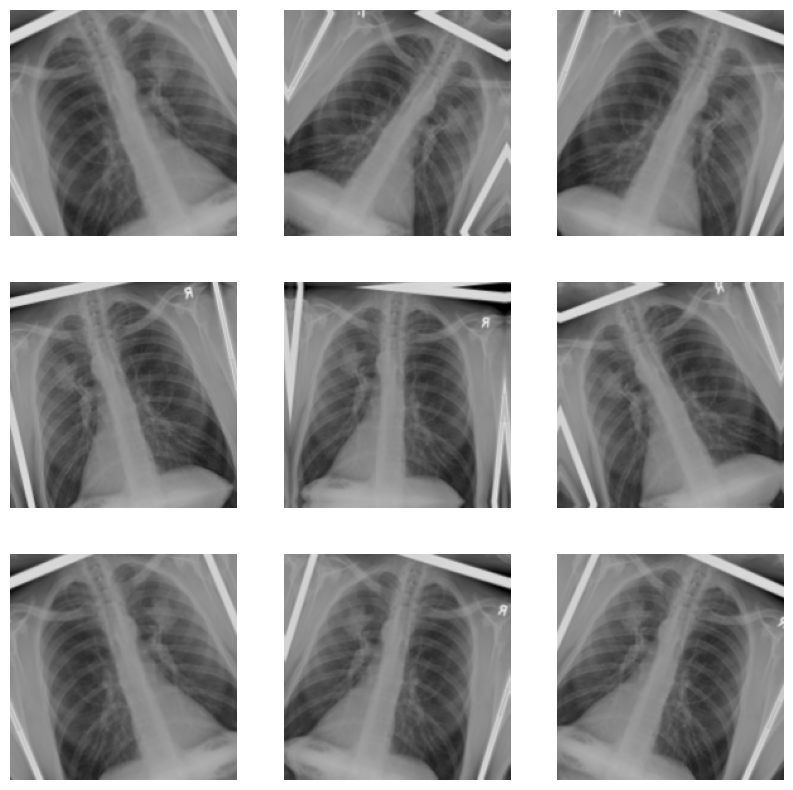

In [30]:
# Create a figure for visualizing augmented images
plt.figure(figsize=(10, 10))

# Loop through the first batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Iterate through the first 9 images
    for i in range(9):
        # Apply data augmentation to the images in the batch
        augmented_images = data_augmentation(images)
        
        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the augmented image as a plot and convert it to uint8 format
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        
        # Turn off the axis to remove axis labels
        plt.axis("off")

In [31]:
# Create a Sequential model for image classification with data augmentation
model = Sequential([
  # Data augmentation pipeline defined earlier
  data_augmentation,
  
  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255),
  
  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),
  
  # Dropout layer to prevent overfitting
  layers.Dropout(0.2),
  
  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),
  
  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),
  
  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])

In [32]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Set the number of training epochs
epochs = 2

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)

Epoch 1/2
639/639 ━━━━━━━━━━━━━━━━━━━━ 406s 630ms/step - accuracy: 0.6188 - loss: 0.7778 - val_accuracy: 0.7207 - val_loss: 0.5482
Epoch 2/2
639/639 ━━━━━━━━━━━━━━━━━━━━ 393s 615ms/step - accuracy: 0.7112 - loss: 0.5491 - val_accuracy: 0.7207 - val_loss: 0.5305


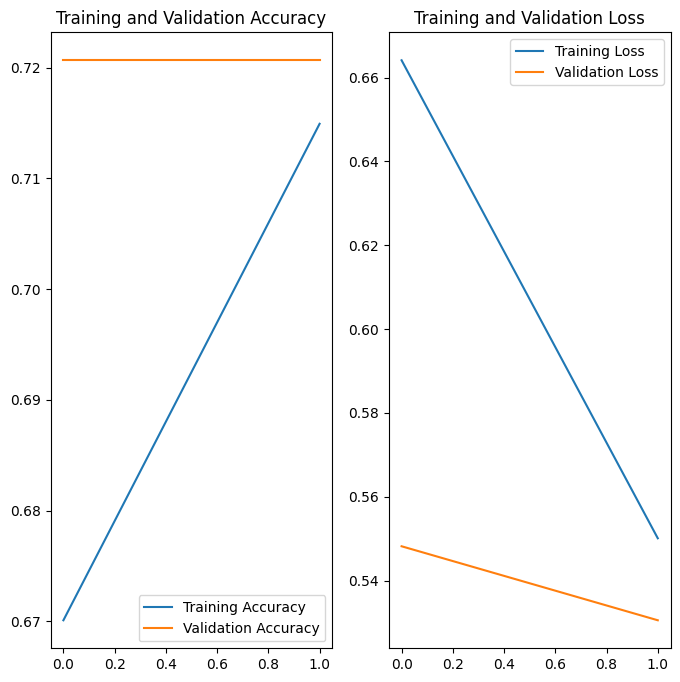

In [36]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()

# Prediction

In [40]:
# Path for testing data
test

PosixPath('/kaggle/input/chest-xray-dataset/test')

In [39]:
# Counting number of images in testing data
image_count = len(list(test.glob('*/*')))
print(image_count)

2569


In [41]:
# Create a TensorFlow dataset for the test data by loading images from the specified directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test,  # Directory containing test images
  seed=123,  # Seed for reproducibility
  image_size=(img_height, img_width),  # Desired image size
  batch_size=batch_size  # Batch size for the dataset
)

Found 2569 files belonging to 3 classes.


In [42]:
model.evaluate(test_ds)

81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 297ms/step - accuracy: 0.7350 - loss: 0.5155


[0.5110616087913513, 0.7349163293838501]

os.listdir(path+'/test/tuberculosis/tuberculosis-590.jpg')
#['pneumonia', 'tuberculosis', 'normal']

In [58]:
# Load an image from the specified path and resize it to the target size
img = tf.keras.utils.load_img(
    path+'/test/tuberculosis/tuberculosis-590.jpg', target_size=(img_height, img_width)
)

# Convert the image to a NumPy array
img_array = tf.keras.utils.img_to_array(img)

# Expand the dimensions of the array to create a batch
img_array = tf.expand_dims(img_array, 0)

In [59]:
# Make predictions on the input image using the trained model
predictions = model.predict(img_array)

# Apply the softmax function to the prediction scores
score = tf.nn.softmax(predictions[0])

# Print the predicted class label and confidence score
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
This image most likely belongs to tuberculosis with a 91.51 percent confidence.


# Things to increase the accuracy

1] greyscale - to heightened the borders